# MAC0460
## Notebook 1 -- Perceptron: toy example

### Definição de algumas funções auxiliares.

Dada uma função linear $\mathbf{w}^T \mathbf{x}$ com $\mathbf{w} \in \mathbb{R}^3$ e $\mathbf{x} \in \mathbb{R}^{1+2}$ (isto é, $\mathbf{x} = (1, x_1, x_2)$),
- calcular o seu valor em um ponto $\mathbf{x}$ dado
- gerar um conjunto de pontos $(x_1,x_2)$ que estejam na reta $\mathbf{w}^T\mathbf{x} = 0$ (isto é feito amostrando-se o eixo $x_1$ de $dx$ em $dx$)
- calcular o sinal de um número (usado depois para calcular o sinal da função $h(\mathbf{x})=\mathbf{w}^T\mathbf{x}$ para um dado $\mathbf{x}$)

Os intervalos nos eixos $x_1$ e $x_2$ estão hard-coded ... podem ser parametrizados.

In [1]:
import numpy as np
import time

# calcula o valor da função w^T x, para um dado w e x
def valor_da_f(w, x):
    return(w.dot(x))
    
    
# calcula x2 tal que h(x) = w^T x = 0, x_1=-0.5,dx,2dx,...,1.5  (intervalo [-0.5,1.5])
def pontos_na_reta(w,dx):
    X1 = []
    X2 = []
    if w[2] != 0:
        x1 = -0.5
        while x1 <= 1.5:
            x2 = -(w[0] + w[1]*x1) / w[2]
            X1.append(x1)
            X2.append(x2)
            x1 = x1+dx
        return X1, X2
    else:  # supondo que w1 != 0
        x2 = -0.5
        while x2 <= 1.5: 
            X1.append(-w0/w1)
            X2.append(x2)
        return X1, X2
    
# devolve +1 se v é > 0 e -1 em caso contrário
def sign_da_f( v ):
    if (v > 0):
        return 1
    else:
        return -1

### Pontos e uma target function
- dataset consistirá dos quatro vértices do quadrado unitário
- definir uma reta $f(x_1,x_2) = w_0 + w_1\,x_1 + w_2\,x_2$ que corta o quadrado $[0,1]\times [0,1]$
- plotar esses pontos de tal forma que pontos $(x_1,x_2)$ tais que $f(x_1,x_2) > 0$ (<font color="blue">positivo</font>) são plotados em <font color="blue">azul</font> e pontos $(x_1,x_2)$ tais que $f(x_1,x_2) < 0$ (<font color="red">negativo</font>) são plotados em <font color="red">vermelho</font>

(4, 2)
(4, 3)


<IPython.core.display.Javascript object>


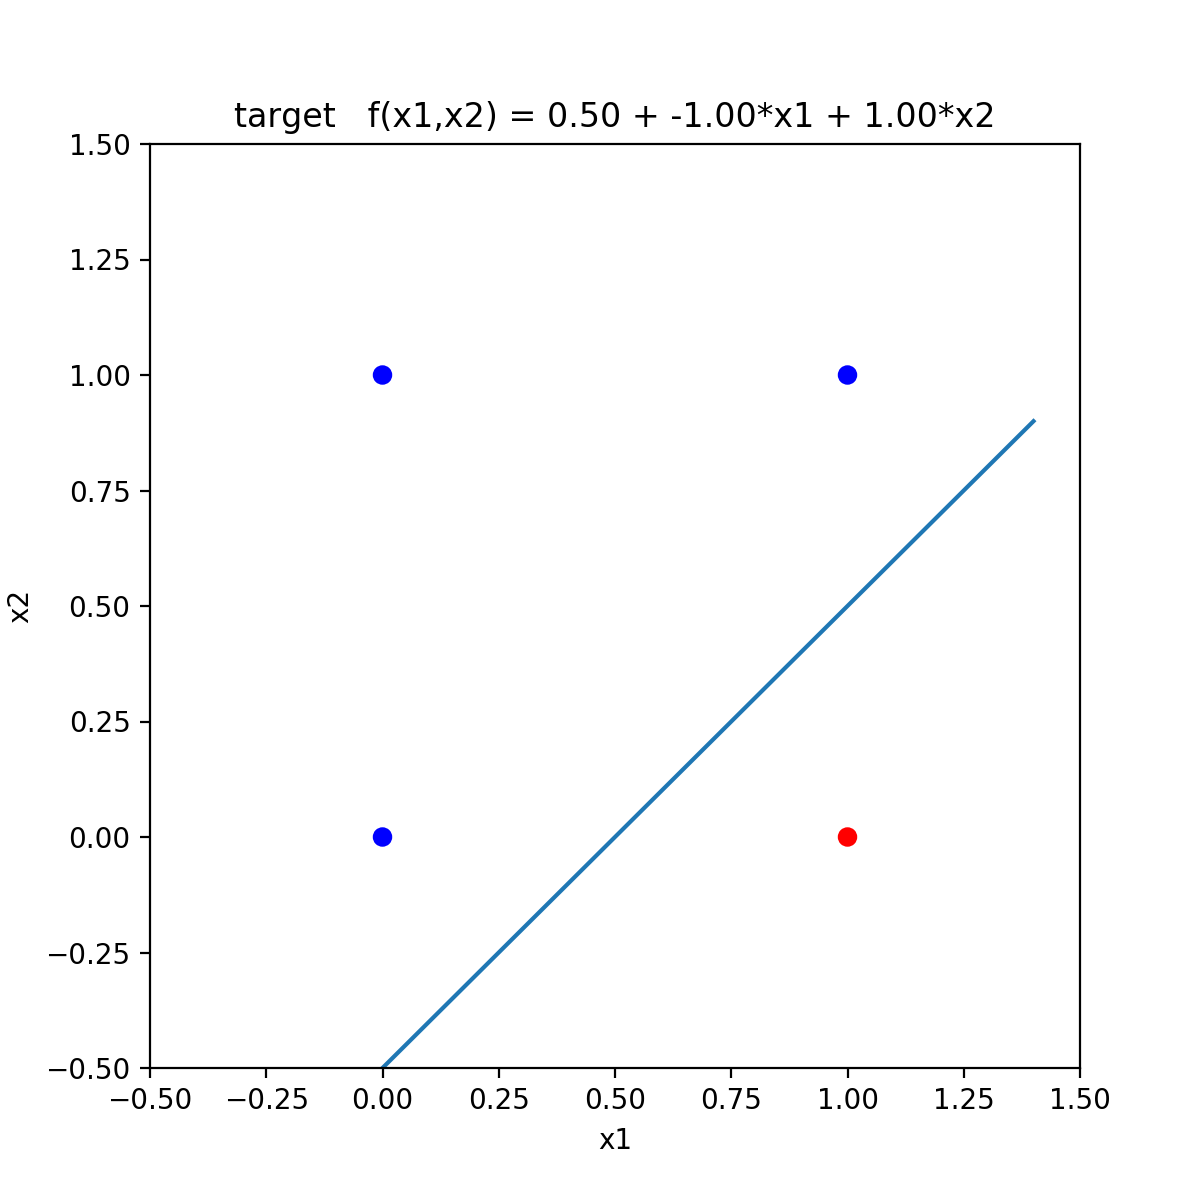

In [2]:
import matplotlib.pyplot as plt
%matplotlib notebook

X = np.asarray([[0,0],[0,1],[1,0],[1,1]])
print(X.shape)

# adicionar uma primeira coluna de 1's em X -- X estendido
Xe = np.hstack(( np.ones((X.shape[0],1)), X ) )
print(Xe.shape)

# definir um vetor de pesos
w = np.asarray([0.5, -1, 1])

# calcular pontos que estão sobre a reta
X1,X2 = pontos_na_reta( w, 0.1 )

# Plotar pontos e a reta que divide o conjunto de pontos
plt.figure(figsize = (6,6))
plt.plot(X1,X2)
colors = ["blue" if valor_da_f(w, Xe[i,:])>0 else "red" for i in range(Xe.shape[0])]
plt.scatter(X[:,0], X[:,1], color=colors)
plt.xlim(-0.5, 1.5)
plt.ylim(-0.5, 1.5)
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("target   f(x1,x2) = %.2f + %.2f*x1 + %.2f*x2" %(w[0],w[1],w[2]))
plt.show()

### Chutar uma hipótese inicial
Plotar o gráfico das amostras com a seguinte convenção:

Cor - ground-truth (definido pela função target acima): <font color="blue">positivo</font> e <font color="red">negativo</font>  
marca o - classificados corretamente pela hipótese<br>
marca x - classificados incorretamente pela hipótese<br>


<IPython.core.display.Javascript object>


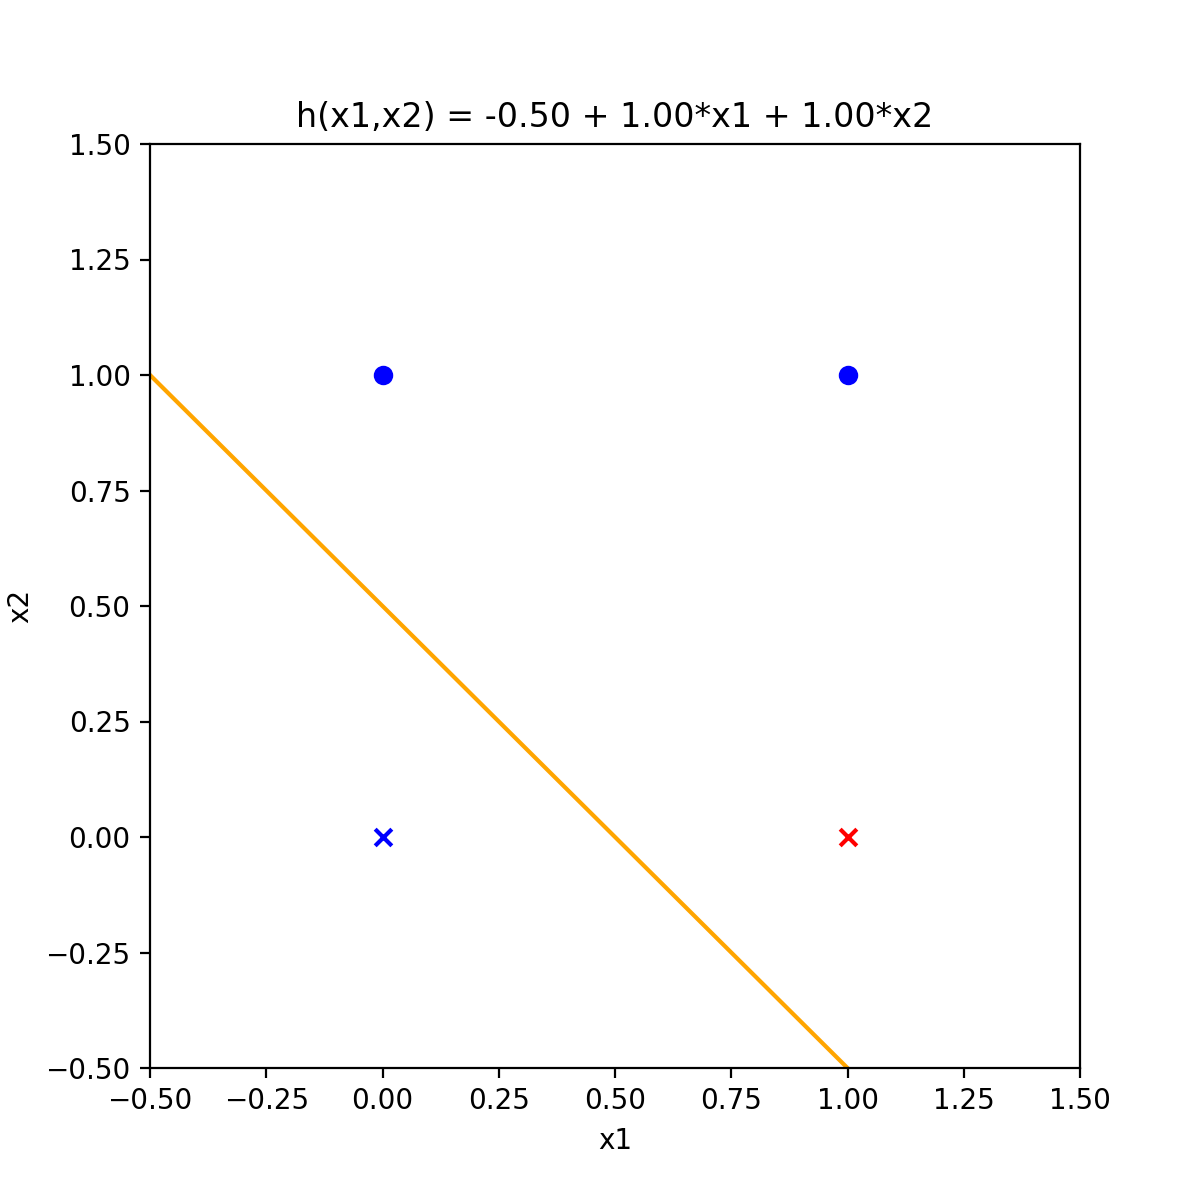

In [3]:
# Dada uma hipótese qualquer, se o sinal coincidir com o original,
# desenha-se bola, se não coincidir, desenha-se x. A cor identifica a classificação correta (ground-truth)

# vetor de pesos para a hipótese inicial
wtil = np.asarray([-0.5, 1 , 1])

# mesma coisa feita acima: calcular pontos na reta definida por esse vetor de pesos
X1,X2 = pontos_na_reta( w, 0.1 )
X1til, X2til = pontos_na_reta(wtil, 0.1)

# mesmo plot acim, porém agora será plotada a hipótese e identificando
# quais pontos estão sendo classificados errado por ela

plt.figure(figsize = (6,6))
# plota a reta chutada
plt.plot(X1til,X2til,c="orange")

# plota com 'o', vermelha ou azul, os pontos onde target e hipótese concordam
# e com 'x' onde elas discordam
colors = ["blue" if valor_da_f(w, Xe[i,:])>0 else "red" for i in range(Xe.shape[0])]
markers = ['o' if sign_da_f(valor_da_f(w, Xe[i,:]))==sign_da_f(valor_da_f(wtil, Xe[i,:])) else 'x' for i in range(Xe.shape[0])]
for _x, _y, _c, _m in zip(X[:,0], X[:,1], colors, markers):
    plt.scatter(_x, _y, marker=_m, color=_c)
    
plt.xlim(-0.5, 1.5)
plt.ylim(-0.5, 1.5)
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("h(x1,x2) = %.2f + %.2f*x1 + %.2f*x2" %(wtil[0],wtil[1],wtil[2]))
plt.show()

# O algoritmo perceptron

### Algoritmo
Itera-se sobre o conjunto de amostras, circularmente. 
Sempre que a hipótese atribui sinal errado a uma amostra, atualiza-se o peso da hipótese: se o sinal correto deveria ser positivo, então soma-se as coordenadas da amostra ao vetor peso; se o sinal deveria ser negativo, subtrai-se as coordenadas da amostra do vetor peso.
Esse processo deve ser continuado, sempre usando o vetor de pesos atualizado, de amostra em amostra. O processo termina quando, ao passar por todas as amostras do dataset com a hipótese atual, nenhum update de pesos ocorre; é a indicação de que o processo convergiu (a hipótese está classificando corretamente todas as amostras).

Para fazer uma animação desse processo, pode-se usar Dynamic ploting 
(veja por exemplo https://github.com/anujgupta82/Musings/blob/master/Dynamic%20or%20Live%20update%20of%20a%20Plot.ipynb) -- convém não fazer animação para dataset muito grande ...

<font color="red">Note que esse algoritmo só converge se os dados são linearmente separáveis.</font>

In [25]:
def atualizar_grafico(Xe, wtil, ax, fig):
    
    ax.clear() # - Clear

    X1til, X2til = pontos_na_reta(wtil, 0.1)
    ax.plot(X1til,X2til,c="orange")
    
    colors = ["blue" if valor_da_f(w, Xe[i,:])>0 else "red" for i in range(Xe.shape[0])]
    markers = ['o' if sign_da_f(valor_da_f(w, Xe[i,:]))==sign_da_f(valor_da_f(wtil, Xe[i,:])) else 'x' for i in range(Xe.shape[0])]
    for _x, _y, _c, _m in zip(X[:,0], X[:,1], colors, markers):
        ax.scatter(_x, _y, marker=_m, color=_c)
        
    plt.xlim(-0.5, 1.5)
    plt.ylim(-0.5, 1.5)
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.title("h(x1,x2) = %.2f + %.2f*x1 + %.2f*x2" %(wtil[0],wtil[1],wtil[2]))
    fig.canvas.draw()
    time.sleep(1)

In [26]:
# Escreva aqui o seu código do algoritmo PERCEPTRON
# Mostre ao menos um plot do resultado final (pontos, target e hipótese final)
# O entendimento do processo pode ser incrmentado com uma animação ou impressão de outras
# informações relacionadas ao processo de treinamento

def PLA(Xe, w, wtil):
    fig = plt.figure(figsize = (6,6))
    ax = fig.add_subplot(111)
    plt.ion()
    fig.show()
    fig.canvas.draw()

    amostras_corretas = {i: 0 for i in range(4)}
    
    while not all(v >= 2 for v in amostras_corretas.values()):
        for i in range(Xe.shape[0]):
            
            amostra_atual = Xe[i, :]
            
            y = sign_da_f(valor_da_f(w, amostra_atual))
            ytil = sign_da_f(valor_da_f(wtil, amostra_atual))
            
            if ytil != y:
                wtil = wtil + y * amostra_atual
                amostras_corretas[i] = 0
                atualizar_grafico(Xe, wtil, ax, fig)
            else:
                amostras_corretas[i] += 1
                             
    
    return wtil

<IPython.core.display.Javascript object>


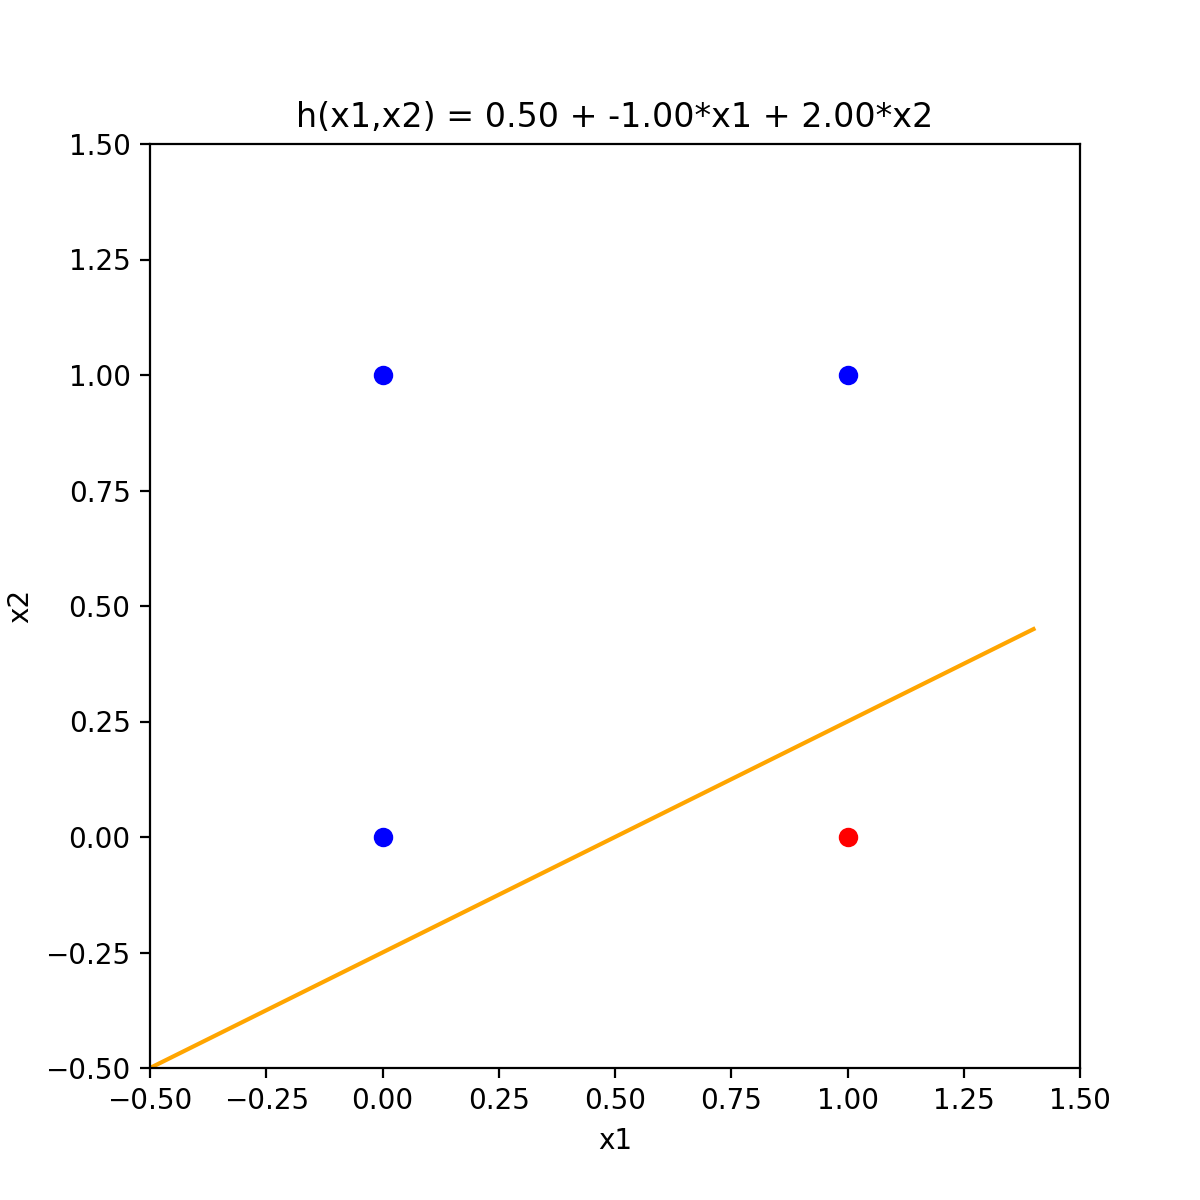

array([ 0.5, -1. ,  2. ])

In [27]:
PLA(Xe, w, wtil)